In [1]:
suppressPackageStartupMessages({
    library(monocle)
    
    library(dplyr)
    library(ggplot2)
})

Warning message:
“replacing previous import by ‘splines::splineDesign’ when loading ‘VGAM’”Warning message:
“replacing previous import by ‘grid::arrow’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘grid::unit’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::clusters’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘ggplot2::Position’ when loading ‘monocle’”

This analysis was made using Monocle version 2.3.5. The source code for Monocle 2.3.5 is available as a supplementary file to Cao et al. 2017 on the Science website. We are working on updating the analysis to the latest version of Monocle.

In [2]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.8 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
[1] dplyr_0.7.1         monocle_2.3.5       DDRTree_0.1.5      
[4] irlba_2.2.1         VGAM_1.0-3          ggplot2_2.2.1      
[7] Biobase_2.30.0      BiocGenerics_0.16.1 Matrix_1.2-7.1     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11           bindr_0.1              RColorBrewer_1.1-2    
 [4] plyr_1.8.4             tools_3.2.1            

In [2]:
# at certain "checkpoints" in this notebook, we save our progress to this RData file
# run this cell to load your progress if you have already reached through one or more checkpoints in the notebook

# IF YOU RUN THIS CELL DO NOT RUN THE CELL BELOW

load("RData/prep_for_vignette.RData")

In [2]:
load("RData/L2.data.summaries.RData")

In [3]:
cds.combined = cds
cds = cds.experiment.1

In [4]:
low.coverage.cells = setdiff(c(colnames(cds.experiment.1), colnames(cds.experiment.2)), colnames(cds.combined))

In [5]:
pData(cds)$tissue = ifelse(
    pData(cds)$Cluster %in% c(10, 26, 30) | pData(cds)$cell %in% doublet.ids.experiment.1,
    "Failed QC", pData(cds)$tissue)

pData(cds)$cell.type = ifelse(
    pData(cds)$Cluster %in% c(10, 26, 30) | pData(cds)$cell %in% doublet.ids.experiment.1,
    "Failed QC", pData(cds)$cell.type)

In [9]:
pData(cds)$cell.type = ifelse(!is.na(pData(cds)$cell.type) & pData(cds)$cell.type == "Pharyngeal.neurons",
    "Pharyngeal neurons", pData(cds)$cell.type)

In [6]:
pData(cds)$fine.grained.neuron.type = NULL
pData(cds)$cluster.name = NULL

In [7]:
pData(cds.neurons)$fine.grained.neuron.type = NULL
pData(cds.neurons)$neuron.type = pData(cds.neurons)$cluster.name
pData(cds.neurons)$cluster.name = NULL

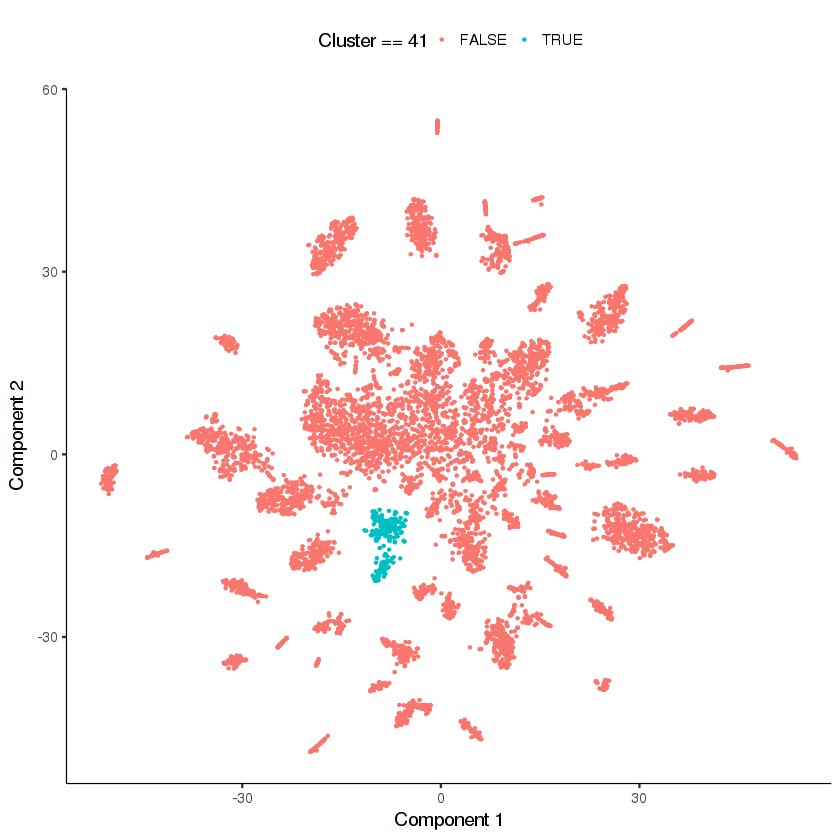

In [8]:
plot_cell_clusters(cds.neurons, color = "Cluster == 41", cell_size = 0.2)

In [9]:
get.norm.expr.matrix = function(cds) {
    sweep(exprs(cds), 2, pData(cds)$Size_Factor, "/")
}

In [10]:
norm.expr.combined = norm.expr
norm.expr = get.norm.expr.matrix(cds.experiment.1)

In [15]:
get.expr.info.by.facet = function(cds, pData.column, exclude = NULL, norm.expr = NULL) {
    cell.assignments = pData(cds)[, pData.column]
    
    if (!(class(cell.assignments) %in% c("factor", "integer", "character"))) {
        message("class(pData(cds)[, pData.column]) must be factor, integer, or character")
    }
    
    if (class(cell.assignments) == "factor") {
        unique.assignments = levels(cell.assignments)
    } else {
        unique.assignments = sort(setdiff(unique(cell.assignments), NA))
    }
    
    if (!is.null(exclude)) {
        unique.assignments = setdiff(unique.assignments, exclude)
    }
    
    if (is.null(norm.expr)) {
        message("Computing normalized expression values")
        norm.expr = sweep(exprs(cds), 2, pData(cds)$Size_Factor, "/")
    }

    facet.norm.expr = list()
    for (facet in unique.assignments) {
        facet.norm.expr[[facet]] = norm.expr[, !is.na(cell.assignments) & cell.assignments == facet]
    }
        
    message("Computing gene expression statistics")

    norm.means = sapply(unique.assignments, function(facet) {
        rowMeans(facet.norm.expr[[facet]])
    })
    
    tpm = sweep(norm.means, 2, apply(norm.means, 2, sum), "/") * 1000000
    
    prop.cells.expr = sapply(unique.assignments, function(facet) {
        apply(facet.norm.expr[[facet]], 1, function(x) sum(x > 0) / length(x))
    })
    
    n.umi = sapply(unique.assignments, function(facet) {
        apply(exprs(cds)[, !is.na(cell.assignments) & cell.assignments == facet],
            1, sum)
    })
    
    total.n.umi.for.facet = sapply(unique.assignments, function(facet) {
        sum(pData(cds)$n.umi[!is.na(cell.assignments) & cell.assignments == facet])
    })

    return(list(
        tpm = tpm,
        prop.cells.expr = prop.cells.expr,
        n.umi = n.umi,
        total.n.umi.for.facet = total.n.umi.for.facet,
        norm.expr = norm.expr,
        gene.annotations = fData(cds),
        facet = pData.column
    ))
}

In [16]:
tissue.expr.info = get.expr.info.by.facet(cds.combined, "tissue",
    exclude = c("Intestinal/rectal muscle", "Coelomocytes", "Excretory cells"),
    norm.expr = norm.expr.combined)

Computing gene expression statistics


In [17]:
cell.type.expr.info = get.expr.info.by.facet(cds.combined, "cell.type",
    exclude = c("Unclassified neurons", "Unclassified glia"),
    norm.expr = norm.expr.combined)

Computing gene expression statistics


In [18]:
neuron.type.expr.info = get.expr.info.by.facet(cds.neurons, "neuron.type",
    exclude = c("Doublets"), norm.expr = neuron.norm.expr)

Computing gene expression statistics


In [19]:
global.cluster.expr.info = get.expr.info.by.facet(cds, "Cluster", norm.expr = norm.expr)

Computing gene expression statistics


In [20]:
get.gene.id = function(symbol, cds = NULL, fData.df = NULL) {
    if (is.null(fData.df))
        fData.df = fData(cds)
    
    if ("gene_id" %in% colnames(fData.df))
        gene.id = as.character(fData.df[fData.df$symbol == symbol, "gene_id"])
    else
        gene.id = as.character(fData.df[fData.df$symbol == symbol, "gene"])

    return(gene.id)
}

In [21]:
show.expr.info = function(gene, expr.info) {
    if (class(expr.info) == "character") {
        expr.info = gsub("[.]", " ", tolower(expr.info))
        if (expr.info == "tissue")
            expr.info = tissue.expr.info
        else if (expr.info == "cell type")
            expr.info = cell.type.expr.info
        else if (expr.info == "neuron type")
            expr.info = neuron.type.expr.info
    }
    
    gene.id = get.gene.id(gene, fData.df = expr.info$gene.annotations)
    data.frame(
        facet = names(expr.info$tpm[gene.id,]),
        tpm = expr.info$tpm[gene.id,],
        prop.cells.expr = expr.info$prop.cells.expr[gene.id,],
        n.umi = expr.info$n.umi[gene.id,],
        total.n.umi.for.facet = expr.info$total.n.umi.for.facet) %>%
    arrange(-tpm)
}

In [23]:
show.expr.info("emb-9", "cell.type")

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
Distal tip cells,16165.15981,0.97520661,3405,202581
Body wall muscle,7972.27222,0.96451347,157028,19390434
Intestinal/rectal muscle,5211.88612,0.84740260,2622,439170
Sex myoblasts,218.24253,0.14776632,75,377288
Pharyngeal neurons,165.12103,0.01592357,14,85381
Other interneurons,137.89861,0.02483070,17,172852
Socket cells,123.75165,0.02793296,26,184774
Coelomocytes,115.46826,0.02503682,71,544263
Non-seam hypodermis,102.41860,0.02006689,56,1059546
Somatic gonad precursors,102.17656,0.06376812,75,823856


In [26]:
show.expr.info("unc-17", "neuron type") %>% head()

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
Cholinergic (23),2944.3520,0.2888889,27,11540
Cholinergic (35),2054.7220,0.2413793,29,13816
Cholinergic (29),1962.7005,0.2786885,177,81950
Cholinergic (3),1230.2431,0.1506494,123,96803
Cholinergic (26),1217.2856,0.1877395,121,93909
Cholinergic (36),901.1702,0.1406250,34,39127


In [11]:
plot.expr = function(cds, gene, thresh = 1, cell_size = 0.1, expr.info = NULL) 
{
    cds.name = deparse(substitute(cds))
    
    gene.id = get.gene.id(gene, cds)
    pData(cds)$tmp.expr = exprs(cds)[gene.id, ] >= thresh
    
    facet = NULL
    if (!is.null(expr.info)) {
        facet = expr.info$facet
        facet.levels = as.character(head(
            subset(show.expr.info(gene, expr.info), n.umi > 0)$facet, 4))
    } else {
        if (cds.name == "cds") {
            facet = "cell.type"
            facet.levels = as.character(head(
                    subset(show.expr.info(gene, cell.type.expr.info), n.umi > 0)$facet, 4))
        } else if (cds.name == "cds.neurons") {
            facet = "neuron.type"
            facet.levels = as.character(head(
                    subset(show.expr.info(gene, neuron.type.expr.info), n.umi > 0)$facet, 4))
        }
    }
    
    if (is.null(facet)) {
        plot = ggplot(pData(cds), aes(x = tsne_1, y = tsne_2, color = tmp.expr, alpha = tmp.expr)) +
            geom_point(size = cell_size) +
            scale_color_manual(values = c("grey60", "firebrick"), labels = c("No", "Yes")) +
            scale_alpha_manual(values = c(0.25, 1.0)) +
            guides(color = guide_legend(title = paste("Expresses ", gene, "?", sep=""),
                                        override.aes = list(size = 4)),
                   alpha = F) +
            monocle:::monocle_theme_opts() +
            theme(legend.position = "left")
    } else {
        facet.name = paste(toupper(substring(facet, 1, 1)), substring(facet, 2), sep = "")
        facet.name = gsub("[._]", " ", facet.name)

        pData(cds)$tmp.facet = pData(cds)[, facet]

        pData(cds)$tmp.expr = with(pData(cds), ifelse(
            tmp.expr & tmp.facet %in% facet.levels, tmp.facet,
                ifelse(tmp.expr,
                    ifelse((!is.na(cell.type) & cell.type == "Failed QC") | cell %in% low.coverage.cells,
                        "Failed QC", "Other/NA"), "Not expressing")))

        pData(cds)$tmp.expr = factor(pData(cds)$tmp.expr,
            levels = c(facet.levels, "Other/NA", "Not expressing", "Failed QC"))

        colors = c("firebrick", "dodgerblue3", "forestgreen", "orchid4", "#FF7F00", "gold", "#FFFF33", "#F781BF")                

        plot = ggplot(pData(cds), aes(x = tsne_1, y = tsne_2, color = tmp.expr,
                                      alpha = tmp.expr != "Not expressing")) +
            geom_point(size = cell_size)

        if ("Other/NA" %in% unique(pData(cds)$tmp.expr))
            plot = plot +
                scale_color_manual(values = c(colors[1:length(facet.levels)], "#A65628", "grey60", "lightsteelblue4"))
        else
            plot = plot +
                scale_color_manual(values = c(colors[1:length(facet.levels)], "grey60", "lightsteelblue4"))

        plot = plot +
            scale_alpha_manual(values = c(0.25, 1.0)) +
            guides(color = guide_legend(title = facet.name, override.aes = list(size = 4)),
                   alpha = F) +
            monocle:::monocle_theme_opts() +
            theme(legend.position = "left")
    }
    
    pData(cds)$tmp.expr = NULL
    pData(cds)$tmp.facet = NULL

    return(plot)
}

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

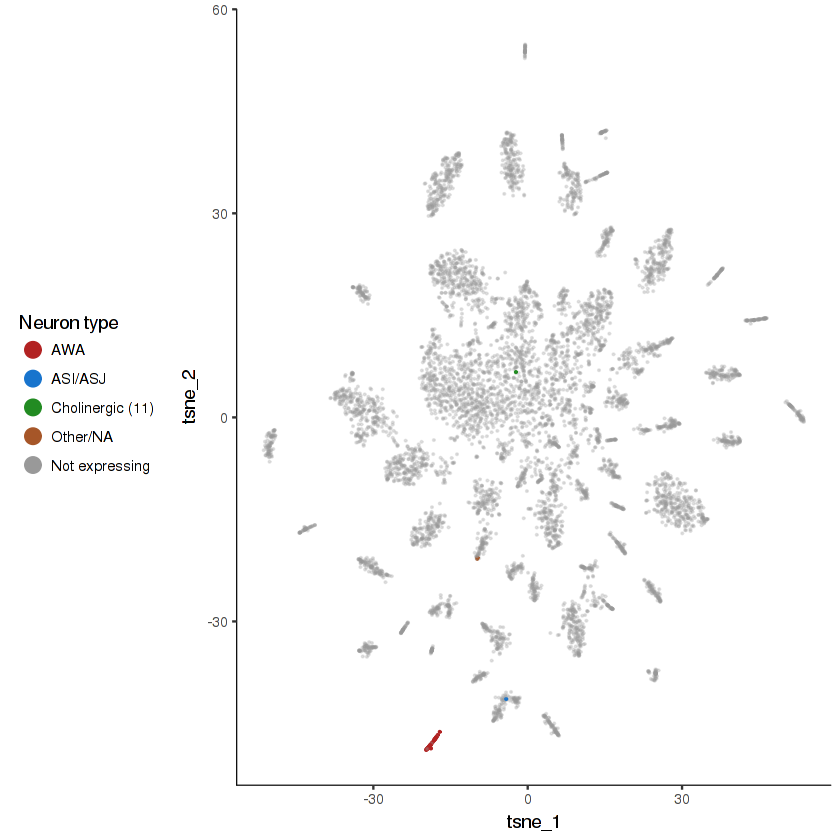

In [42]:
plot.expr(cds.neurons, "odr-10")

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

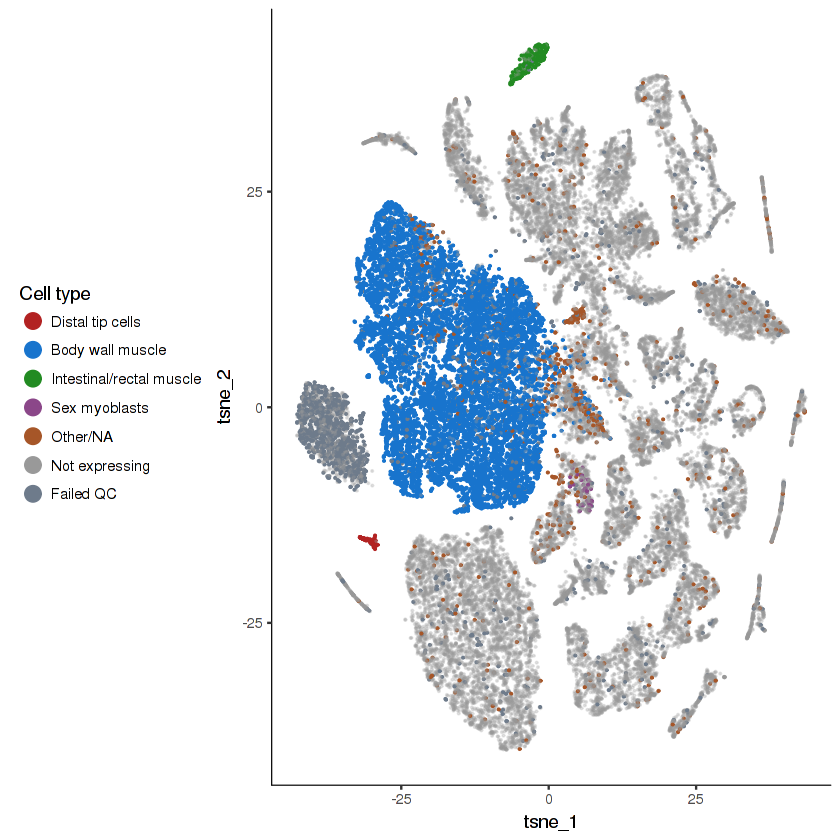

In [22]:
plot.expr(cds, "emb-9")

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

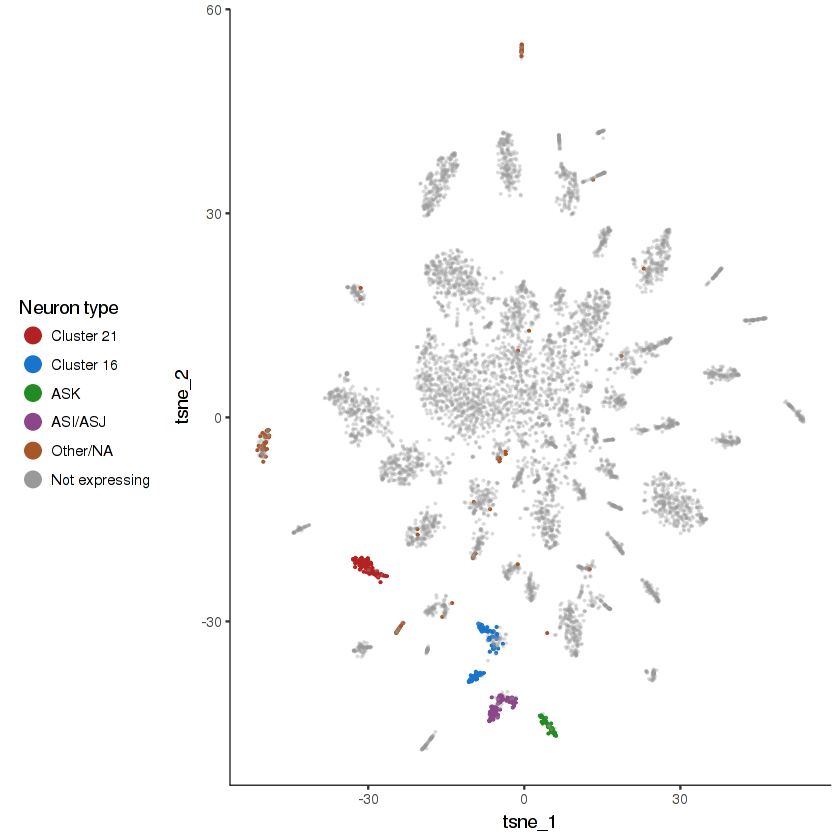

In [43]:
plot.expr(cds.neurons, "R102.2")

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

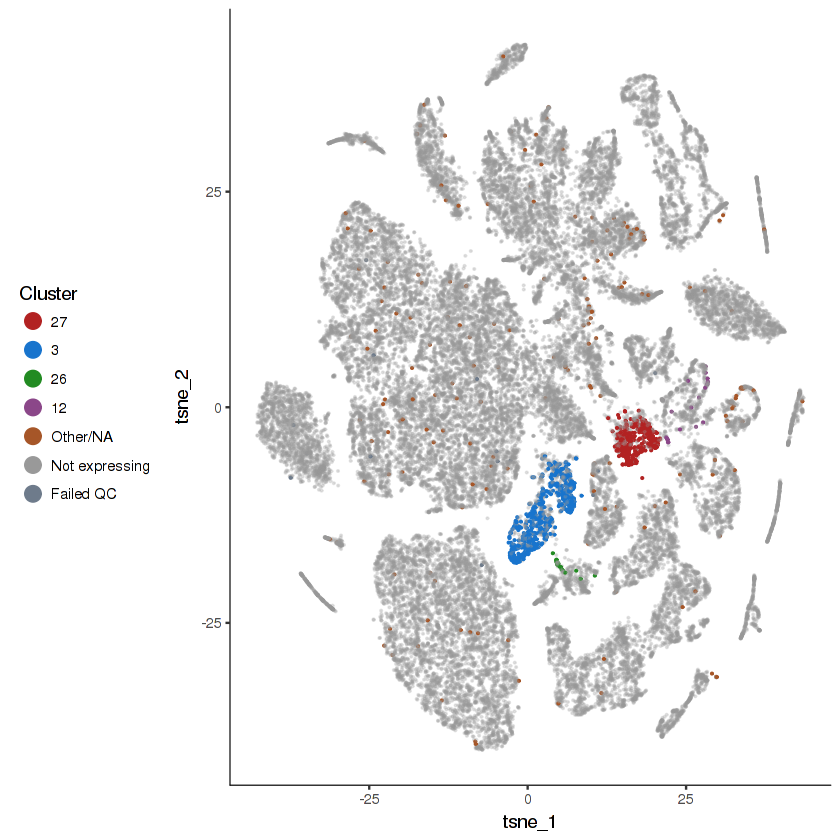

In [46]:
plot.expr(cds, "lin-12", expr.info = global.cluster.expr.info)

In [47]:
two.set.differential.gene.test = function(cds, set.1.filter, set.2.filter, formal = F, cores = 1) {
    message(paste("# of cells in set 1:", sum(set.1.filter)))
    message(paste("# of cells in set 2:", sum(set.2.filter)))
    
    s1.cds = cds[, set.1.filter]
    s2.cds = cds[, set.2.filter]

    s1.norm.expr = sweep(exprs(s1.cds), 2, pData(s1.cds)$Size_Factor, "/")
    s2.norm.expr = sweep(exprs(s2.cds), 2, pData(s2.cds)$Size_Factor, "/")
    
    s1.tpm = apply(s1.norm.expr, 1, sum)
    s1.tpm = s1.tpm / sum(s1.tpm) * 1000000
    s2.tpm = apply(s2.norm.expr, 1, sum)
    s2.tpm = s2.tpm / sum(s2.tpm) * 1000000
    
    s1.n.umi = apply(exprs(s1.cds), 1, sum)
    s2.n.umi = apply(exprs(s2.cds), 1, sum)
    
    higher.expr = ifelse(s1.tpm > s2.tpm, "Set 1", "Set 2")
    
    s1.ratio = s1.tpm / (s2.tpm + 1)
    s2.ratio = s2.tpm / (s1.tpm + 1)
    log2.ratio = ifelse(
        s1.tpm == 0 & s2.tpm == 0, 0, ifelse(
            higher.expr == "Set 1", log2(s1.ratio), log2(s2.ratio)))
    
    s1.n.expr = apply(exprs(s1.cds), 1, function(x) sum(x > 0))
    s2.n.expr = apply(exprs(s2.cds), 1, function(x) sum(x > 0))
        
    s1.precision = s1.n.expr / (s1.n.expr + s2.n.expr)
    s1.recall = s1.n.expr / ncol(s1.cds)
    s2.precision = s2.n.expr / (s1.n.expr + s2.n.expr)
    s2.recall = s2.n.expr / ncol(s2.cds)
    
    precision = ifelse(higher.expr == "Set 1", s1.precision, s2.precision)
    recall = ifelse(higher.expr == "Set 1", s1.recall, s2.recall)
        
    f.score = 2 * precision * recall / (precision + recall)
        
    res = data.frame(
        gene = fData(cds)$symbol,
        set.1.n.umi = s1.n.umi,
        set.2.n.umi = s2.n.umi,
        set.1.tpm = s1.tpm,
        set.2.tpm = s2.tpm,
        higher.expr = higher.expr,
        log2.ratio = log2.ratio,
        precision = precision,
        recall = recall,
        f.score = f.score
    ) %>% arrange(-f.score)
        
    if (formal) {
        pData(cds)$tmp = ifelse(set.1.filter, 1, ifelse(set.2.filter, 2, NA))
        
        cds.subset = cds[, set.1.filter | set.2.filter]
        cds.subset = estimateSizeFactors(cds.subset)
        #cds.subset = estimateDispersions(cds.subset)
        cds.subset = detectGenes(cds.subset, 0.1)
        
        expressed.genes = subset(fData(cds.subset), num_cells_expressed >= 5)[, 1]
        message(paste(length(expressed.genes), "genes expressed in at least 5 cells across both sets"))
        message("Computing differential expression p-values")

        DEG = differentialGeneTest(cds.subset[expressed.genes,],
            fullModelFormulaStr = "~ tmp", cores = cores)
        
        res = inner_join(res,
            DEG %>% select(gene = symbol, p.val = pval, q.val = qval),
            by = "gene") %>% arrange(q.val)
        
        pData(cds)$tmp = NULL
    }

    return(res)
}

In [48]:
is.tissue = function(cds, x) {
    with(pData(cds), !is.na(tissue) & tissue == x)
}

is.cell.type = function(cds, x) {
    with(pData(cds), !is.na(cell.type) & cell.type == x)
}

is.neuron.type = function(cds, x) {
    with(pData(cds), !is.na(neuron.type) & neuron.type == x)
}

in.cluster = function(cds, x) {
    pData(cds)$Cluster == x
}

In [49]:
expresses.gene = function(cds, gene) {
    exprs(cds)[get.gene.id(gene, cds),] > 0
}

In [35]:
system.time({

zork = two.set.differential.gene.test(cds.neurons,
    is.neuron.type(cds.neurons, "ASEL"),
    is.neuron.type(cds.neurons, "ASER"),
    formal = T, cores = min(16, detectCores()))
})

# of cells in set 1: 37
# of cells in set 2: 35
756 genes expressed in at least 5 cells across both sets
Computing differential expression p-values
Warning message:
“closing unused connection 19 (<-localhost:11693)”Warning message:
“closing unused connection 18 (<-localhost:11693)”Warning message:
“closing unused connection 17 (<-localhost:11693)”Warning message:
“closing unused connection 16 (<-localhost:11693)”Warning message:
“closing unused connection 15 (<-localhost:11693)”Warning message:
“closing unused connection 14 (<-localhost:11693)”Warning message:
“closing unused connection 13 (<-localhost:11693)”Warning message:
“closing unused connection 12 (<-localhost:11693)”Warning message:
“closing unused connection 11 (<-localhost:11693)”Warning message:
“closing unused connection 10 (<-localhost:11693)”Warning message:
“closing unused connection 9 (<-localhost:11693)”Warning message:
“closing unused connection 8 (<-localhost:11693)”Warning message:
“closing unused connection 7 (<-l

   user  system elapsed 
 21.271   6.665 155.973 

In [36]:
zork %>% head(20)

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,log2.ratio,higher.expr,precision,recall,f.score,p.val,q.val
gcy-3,0,147,0.00000,9593.506,13.227842,Set 2,1.0000000,0.7428571,0.8524590,1.238145e-11,9.360380e-09
gcy-22,0,129,0.00000,8862.360,13.113475,Set 2,1.0000000,0.8000000,0.8888889,2.699776e-11,1.020515e-08
tank-1,20,570,1794.18829,36169.778,4.332578,Set 2,0.8536585,1.0000000,0.9210526,4.789133e-11,1.206861e-08
gcy-6,66,0,6909.70464,0.000,12.754408,Set 1,1.0000000,0.7297297,0.8437500,1.053208e-08,1.487185e-06
gcy-17,69,0,6553.87356,0.000,12.678132,Set 1,1.0000000,0.6216216,0.7666667,1.180306e-08,1.487185e-06
K09F6.9,0,75,0.00000,5925.954,12.532832,Set 2,1.0000000,0.5428571,0.7037037,1.161684e-08,1.487185e-06
gcy-14,56,0,6083.64917,0.000,12.570721,Set 1,1.0000000,0.4864865,0.6545455,5.726900e-08,6.185052e-06
K09F6.10,0,70,0.00000,4441.100,12.116701,Set 2,1.0000000,0.5428571,0.7037037,1.497514e-07,1.415151e-05
gcy-20,53,0,5339.03657,0.000,12.382364,Set 1,1.0000000,0.5945946,0.7457627,2.071163e-07,1.739777e-05
tyra-2,0,58,0.00000,3753.158,11.873889,Set 2,1.0000000,0.5142857,0.6792453,7.604916e-07,5.749317e-05


In [37]:
unique(pData(cds)$tissue)

[1] "Neurons"                  "Gonad"                   
 [3] "Intestinal/rectal muscle" NA                        
 [5] "Coelomocytes"             "Failed QC"               
 [7] "Hypodermis"               "Pharynx"                 
 [9] "Body wall muscle"         "Glia"                    
[11] "Excretory cells"

In [50]:
tissues = c("Body wall muscle", "Pharynx", "Hypodermis", "Neurons", "Glia", "Gonad", "Intestine")

In [51]:
cell.types = sort(setdiff(unique(pData(cds.combined)$cell.type),
    c(NA, "Unclassified neurons", "Unclassified glia", "Failed QC")))

In [52]:
neuron.types = sort(setdiff(unique(pData(cds.neurons)$neuron.type), c(NA, "Failed QC", "Doublets")))

In [15]:
save(
    file = "RData/Cao_et_al_2017_vignette.RData",
    list = c(
        "cds", "cds.neurons", "cds.experiment.2",
        "norm.expr", "low.coverage.cells",
        "tissue.expr.info", "cell.type.expr.info", "neuron.type.expr.info",
        "global.cluster.expr.info",
        "get.norm.expr.matrix", "get.expr.info.by.facet",
        "get.gene.id", "plot.expr", "show.expr.info", "two.set.differential.gene.test",
        "tissues", "cell.types", "neuron.types",
        "is.tissue", "is.cell.type", "is.neuron.type", "in.cluster", "expresses.gene"))

In [14]:
save.image("RData/prep_for_vignette.RData")